In [1]:
import tensorflow as tf
from tensorflow.keras.initializers import RandomNormal
import os
import matplotlib.pyplot as plt
from IPython import display

Download the cityscapes dataset

In [2]:
_URL ='https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/cityscapes.tar.gz'

path_to_zip = tf.keras.utils.get_file('cityscapes.tar.gz',
                                      origin=_URL,
                                      extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cityscapes/')

# Preprocessing data


In [3]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

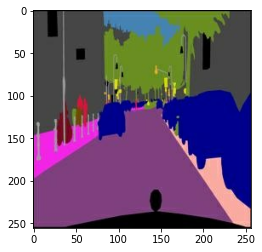

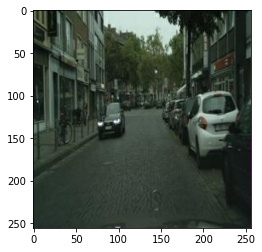

In [4]:
inp, re = load(PATH+'train/100.jpg')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [5]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 128
IMG_HEIGHT = 128
LAMBDA = 100

Resize images to (128,128) with NEAREST_NEIGHBOR method

Normalize them to [-1,1]

Flip images from left to right



In [6]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

# normalizing the images to [-1, 1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image


@tf.function()
def random_jitter(input_image, real_image):
    # resizing to 128 x 128 x 3
    input_image, real_image = resize(input_image, real_image, 128, 128)


    if tf.random.uniform(()) > 0.5:
        # random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image





In [7]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [8]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.list_files(PATH+'val/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Generator architecture

Encoder | Bottleneck | Decoder
--- | --- | ---
CL(32,4,2) | CR(256,4,2) | TBDR(256,4,2)
CBL(64,4,2) |  | TBDR(128,4,2)
CBL(128,4,2) |  | TBR(64,4,2)
CBL(256,4,2) |  | TBR(32,4,2)
| | Tt(3,4,2)

 Acronyms: C=convolution, B=batch normalization, L= leaky relu(alpha=0.2), D=dropout, R=relu,
T=transpose convolution, t=tanh. 

The numbers in parentheses indicate the number of ﬁlters, ﬁlter size, and stride of the convolution
ﬁlters, respectively.

Initialize weights with mean=0 and Standard deviation=0.02

In [9]:
from tensorflow.keras.layers import Conv2D, Dropout,Activation,BatchNormalization, Conv2DTranspose, LeakyReLU

In [10]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add convolution layer
	x = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		x = BatchNormalization()(x, training=True)
	# leaky relu activation
	x = LeakyReLU(alpha=0.2)(x)
	return x

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add transpose convolution layer
	x = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	x = BatchNormalization()(x, training=True)
	# conditionally add dropout
	if dropout:
		x = Dropout(0.5)(x, training=True)
	# merge with skip connection
	x = tf.keras.layers.Concatenate()([x, skip_in])
	# relu activation
	x = Activation('relu')(x)
	return x

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   3136        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 128)  131200      leaky_re_lu[0][0]                
______________________________________________________________________________________________

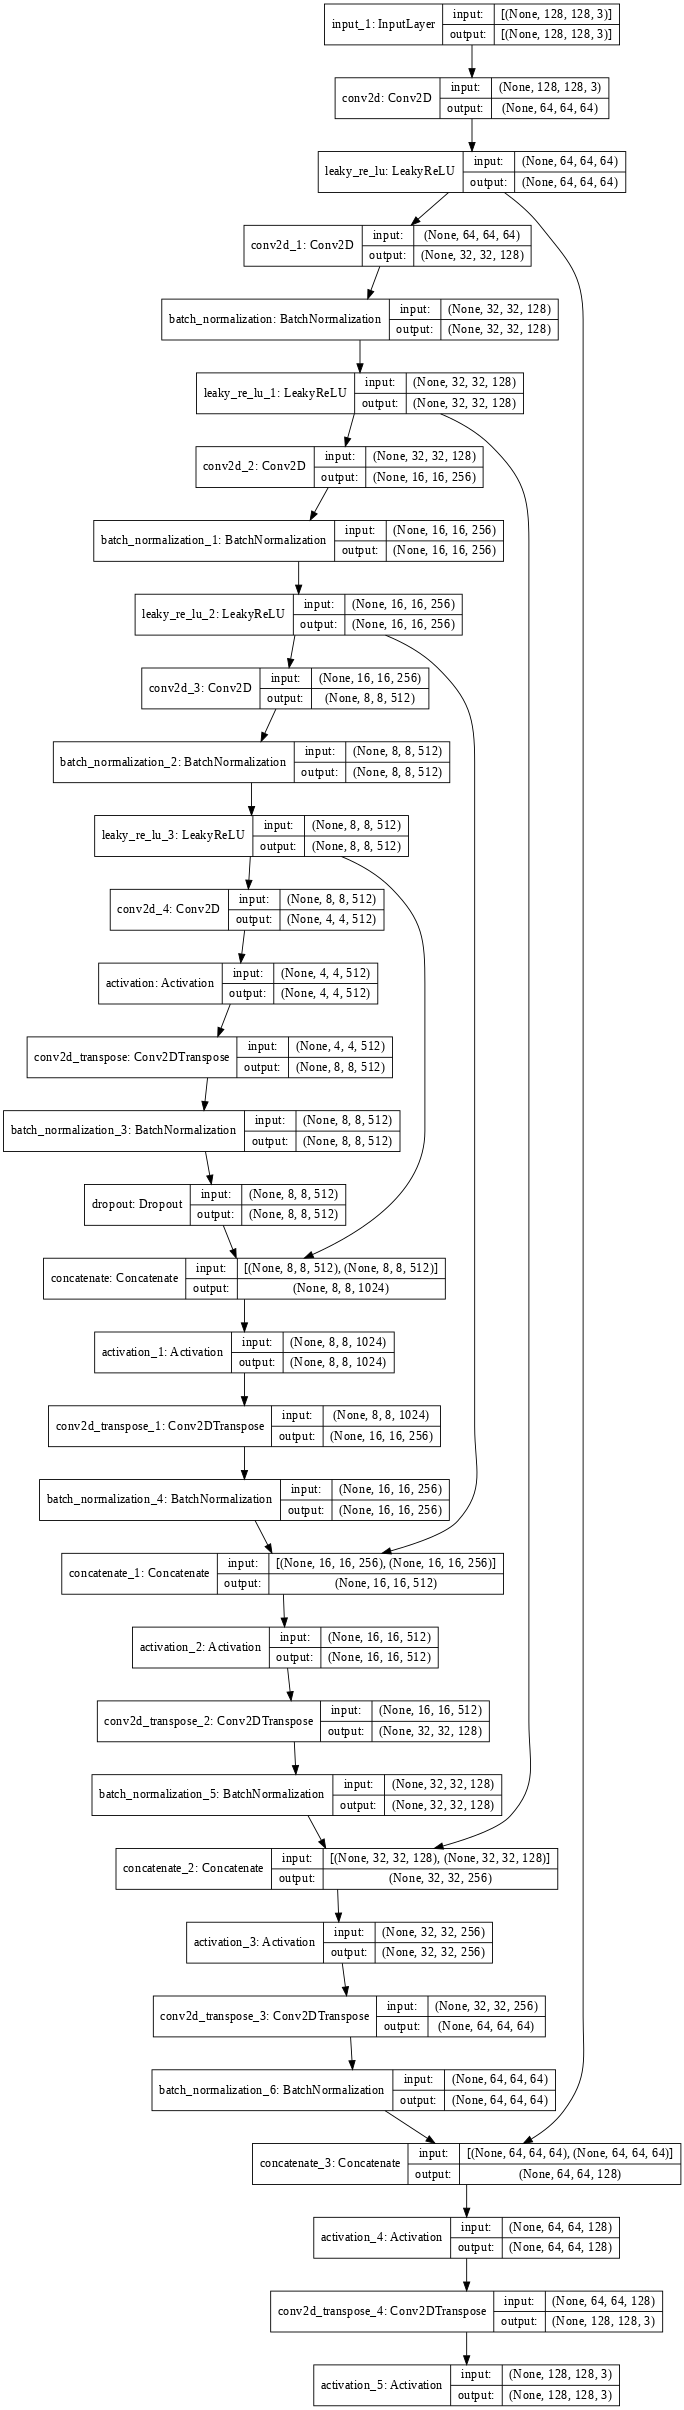

In [11]:
# define the Unet model
def Generator():
	# weight initialization
	init = tf.random_normal_initializer(0., 0.02)
	# image input
	in_image = tf.keras.layers.Input(shape=[128,128,3])
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)

	# bottleneck, conv and relu activation
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e4)
	b = Activation('relu')(b)
  
	# decoder model
	d1 = decoder_block(b, e4, 512)
	d2 = decoder_block(d1, e3, 256, dropout=False)
	d3 = decoder_block(d2, e2, 128, dropout=False)
	d4 = decoder_block(d3, e1, 64, dropout=False)
	# Conv2D Transpose
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d4)
  # Tanh activation
	out_image = Activation('tanh')(g)
	# define model
	model = tf.keras.Model(in_image, out_image)
	return model

Generator = Generator()
Generator.summary()
tf.keras.utils.plot_model(Generator, show_shapes=True, dpi=64)

Calculate mean absolute error between target and gen_output

In [12]:
def Generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

# Discriminator architecture

--- | Discriminator | ---
--- | --- | ---
--- | CBL(64,4,2) | ---
--- | CBL(128,4,2) | ---
--- | CBL(256,4,2) | ---
--- | CBL(512,4,2) | ---
| C(1,3,1) | ---

 Acronyms: C=convolution, B=batch normalization, L= leaky relu(alpha=0.2). 

The numbers in parentheses indicate the number of ﬁlters, ﬁlter size, and stride of the convolution
ﬁlters, respectively.

Initialize weights with mean=0 and Standard deviation=0.02

In [13]:
def downsample(filters, size, norm_type='batchnorm', apply_norm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_norm:
    if norm_type.lower() == 'batchnorm':
      result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
      result.add(InstanceNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

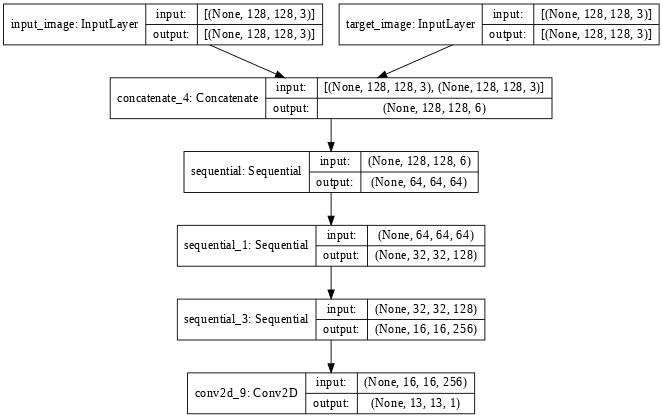

In [14]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[128, 128, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[128, 128, 3], name='target_image')

  
  x = tf.keras.layers.concatenate([inp, tar]) 

  down1 = downsample(64, 4, "batchnorm", False)(x)  # (bs, 128, 128, 64)
  down2 = downsample(128, 4, "batchnorm")(down1)  # (bs, 64, 64, 128)
  down3 = downsample(256, 4, "batchnorm")(down2)  # (bs, 32, 32, 256)
  down4 = downsample(256, 4, "batchnorm")(down2)  # (bs, 32, 32, 256)
  #Convolution
  last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(down4)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

Discriminator = Discriminator()
tf.keras.utils.plot_model(Discriminator, show_shapes=True, dpi=64)

Use Adam optimizer with learning rate=0.0002 and beta_1=0.5 

BinaryCrossentropy with from_logits=True

In [15]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def Discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output) 

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss



Generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
Discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [16]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

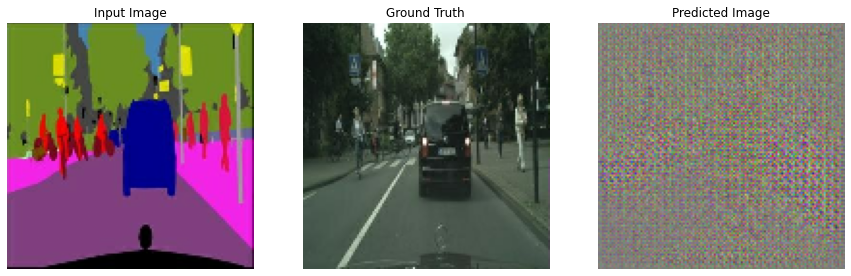

In [17]:
for example_input, example_target in test_dataset.take(1):
  generate_images(Generator, example_input, example_target)

In [18]:
EPOCHS = 30

@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = Generator(input_image, training=True)

    disc_real_output = Discriminator([input_image, target], training=True)
    disc_generated_output = Discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = Generator_loss(disc_generated_output, gen_output, target)
    disc_loss = Discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss, Generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,  Discriminator.trainable_variables)

  Generator_optimizer.apply_gradients(zip(generator_gradients, Generator.trainable_variables))
  Discriminator_optimizer.apply_gradients(zip(discriminator_gradients,  Discriminator.trainable_variables))

In [19]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(Generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

#Fit models

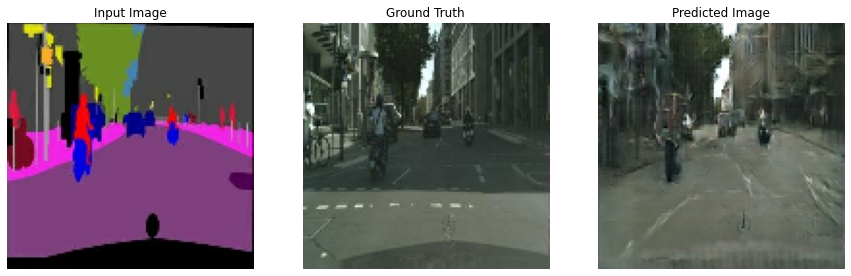

Epoch:  29
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
................................................................................

In [20]:
fit(train_dataset, 30, test_dataset)

#Predicts

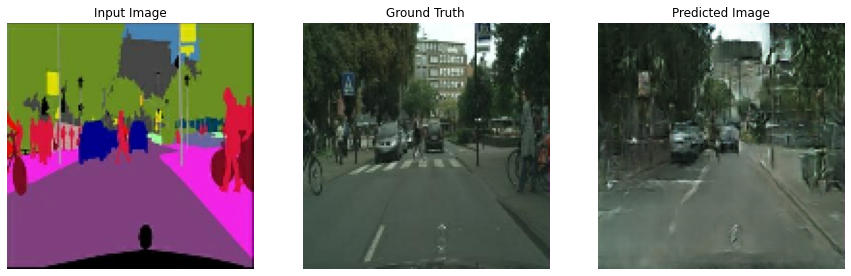

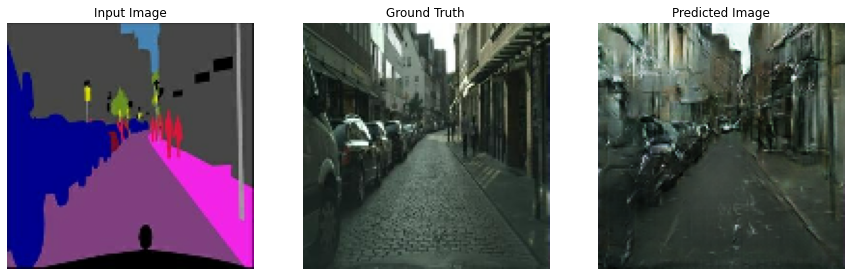

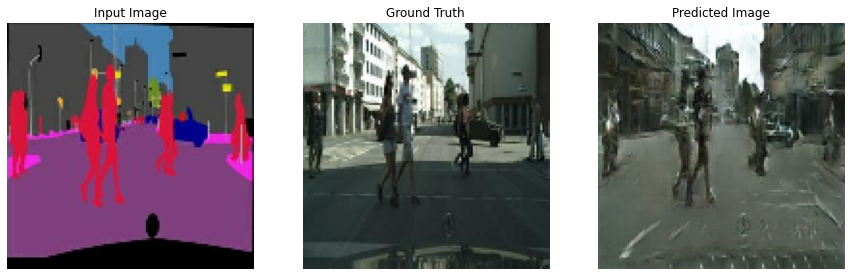

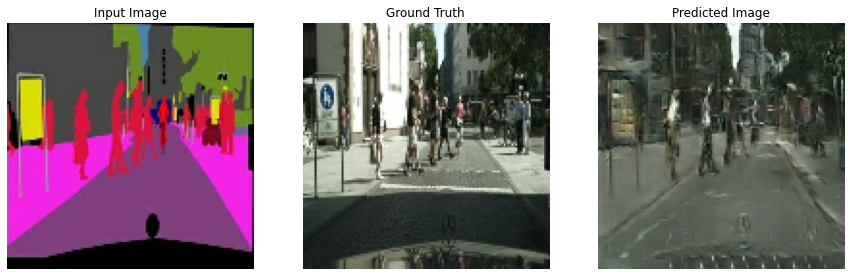

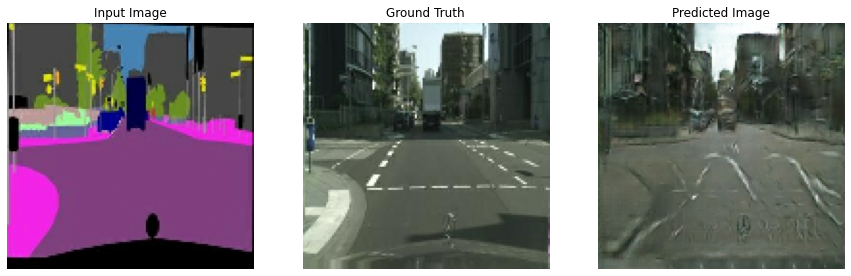

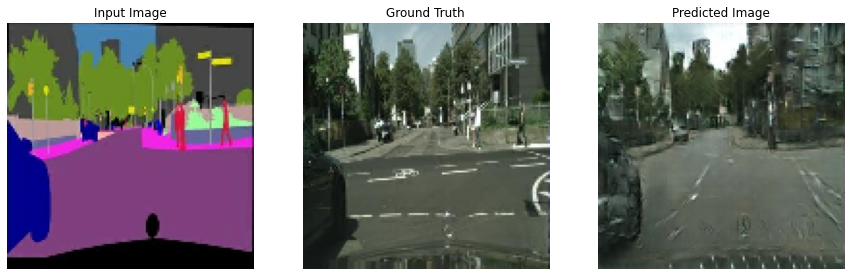

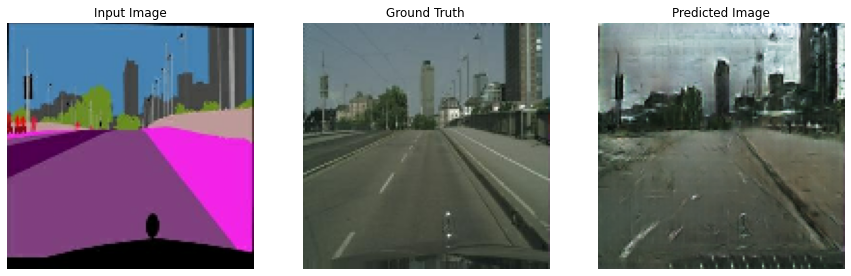

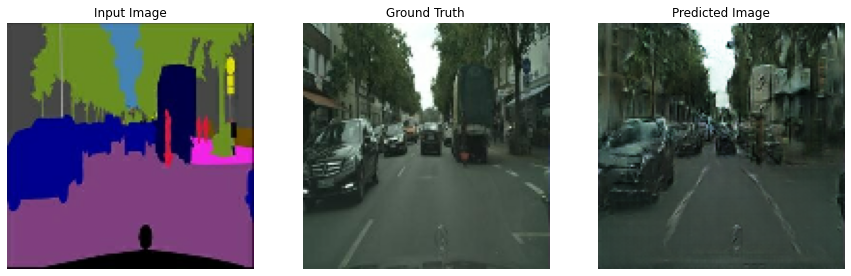

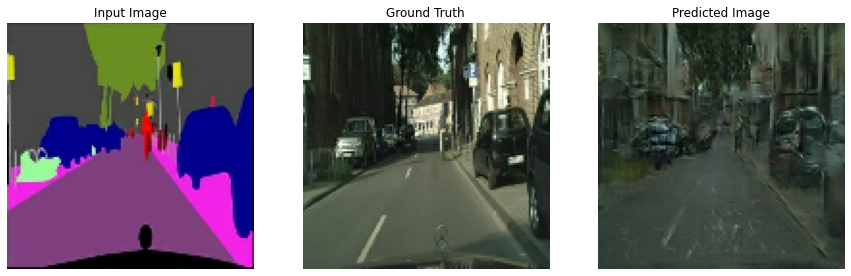

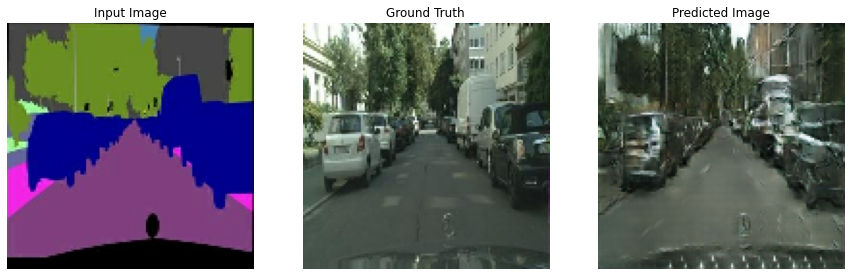

In [21]:
for example_input, example_target in test_dataset.take(10):
  generate_images(Generator, example_input, example_target)